# Prédiction du défaut de prêt

Ce document présente une analyse complète du risque de défaut de paiement à partir d’un ensemble de données de prêts. L’objectif est de développer, tester et comparer différents modèles de classification afin d’identifier les emprunteurs susceptibles de faire défaut. L’ensemble du processus s’appuie sur une démarche rigoureuse incluant la préparation des données, l’entraînement de modèles, l’évaluation, ainsi que le suivi expérimental via MLflow.


Ce notebook décrit méthodiquement les étapes de mise en œuvre des modèles de prédiction du défaut de prêt. Il comprend la configuration de l’environnement, la préparation des données, l’entraînement des modèles, ainsi que la journalisation des expériences à l’aide de MLflow pour assurer la traçabilité des paramètres, des métriques et des artefacts.


---

## 1. Configuration de l’environnement

Dans cette section, nous initialisons les bibliothèques nécessaires et définissons les paramètres de base pour garantir la reproductibilité des expériences. Nous configurons également MLflow afin de suivre systématiquement les modèles développés et leurs performances.


In [1]:
import mlflow
from mlflow.tracking import MlflowClient

import numpy as np
import pandas as pd

import joblib

In [2]:
# Définir les variables d'environnement
data_path = "Data/datasetfinal.csv"
models_path = "Models/"
random_seed = 42  # Set the random seed for reproducibility

### Configuration de MLflow

MLflow est utilisé pour suivre les expériences, consigner les métriques, sauvegarder les artefacts et assurer la comparabilité entre différents modèles. La configuration locale permet de centraliser les résultats dans un répertoire dédié.


## Guide rapide : lancer MLflow en local

1. **Ouvrir un terminal** dans le dossier du projet.
2. **Activer l’environnement virtuel** (si nécessaire).
3. **Démarrer l’interface MLflow** avec la commande :

   ```bash
   python -m mlflow ui
4. Ouvrir MLflow dans le navigateur à l’adresse suivante :http://127.0.0.1:5000

In [4]:
try:
    # 1️⃣ Suivi LOCAL dans un dossier "mlruns" à côté de ton script
    LOCAL_TRACKING_URI = "file:./mlruns"   # ou un chemin absolu vers ton projet

    mlflow.set_tracking_uri(LOCAL_TRACKING_URI)
    client = mlflow.MlflowClient()

    print("Connected to LOCAL MLflow tracking (file store)")
except Exception as e:
    print(f"Failed to connect to local MLflow tracking: {e}")


Connected to LOCAL MLflow tracking (file store)


---

## 2. Prétraitement des données

Cette partie consiste à préparer les données pour les modèles. Elle inclut :
- le nettoyage et la vérification des valeurs manquantes,
- la définition de la variable cible et des variables explicatives,
- la séparation des données en ensembles d’entraînement et de test.

Ces étapes garantissent une base saine pour l’entraînement des modèles.


In [5]:
df = pd.read_csv(data_path)
df.head()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,loan_amt_outstanding_norm
0,0,0.747058,-0.724812,0.398535,0.285411,-0.536743,False,0.747058
1,5,-1.548297,-0.073963,-2.161768,-1.629243,-1.080777,True,-1.548297
2,0,-0.560481,-1.009645,-0.207909,-0.352807,-0.586201,False,-0.560481
3,0,0.427024,-0.938137,0.215073,0.285411,-0.421342,False,0.427024
4,1,-1.979634,-1.048728,-2.321198,0.923629,-0.108110,False,-1.979634


In [6]:
# Séparer les données en variables explicatives (features) et variable cible
X = df.drop("default", axis=1)
y = df["default"]
X.shape, y.shape

((10000, 7), (10000,))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 7), (2000, 7), (8000,), (2000,))

---

## 3. Expérimentation des modèles

Nous entraînons et comparons plusieurs modèles de classification afin d’identifier celui offrant les meilleures performances prédictives. Les modèles sont évalués selon plusieurs métriques : précision, rappel, F1-score, matrice de confusion, etc. Chaque expérience est journalisée dans MLflow.


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def eval_log_model(model, X_test, y_test, y_pred, params, run_name):
    """
    Évaluer et journaliser un modèle.

    Paramètres
    ----------
    X_test (array-like): Données de caractéristiques de test.
    y_test (array-like): Données cibles de test.
    params (dict): Paramètres du modèle de régression logistique.
    run_name (str): Nom du run MLflow.

    Retourne
    --------
    dict: Dictionnaire contenant les métriques d'évaluation.
    matplotlib.figure.Figure: Figure de la matrice de confusion.
    """
    
    # Generate a classification report and confusion matrix
    class_report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Extract confusion matrix values
    tn, fp, fn, tp = conf_matrix.ravel().astype(int)
    
    # Extract evaluation metrics for the 'default' and 'no_default' classes
    default_precision, default_recall, default_f1_score, _ = class_report["True"].values()
    no_default_precision, no_default_recall, no_default_f1_score, _ = class_report["False"].values()
    
    # Create and display the confusion matrix
    fig, ax = plt.subplots(figsize=(7, 6))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["no_default", "default"])
    cm_display.plot(ax=ax, cmap="Blues")  # Use the 'Blues' colormap for blue colors
    ax.set_title("Confusion Matrix")  # Add a title
    
    # Compile evaluation metrics into a dictionary
    metrics = {
        "default_precision": default_precision,
        "default_recall": default_recall,
        "default_f1_score": default_f1_score,
        "no_default_precision": no_default_precision,
        "no_default_recall": no_default_recall,
        "no_default_f1_score": no_default_f1_score,
        "false_positives": int(fp),
        "false_negatives": int(fn),
    }
    metrics = {k:round(v,2) for k,v in metrics.items()}
    
    # Log the model and metrics in MLflow
    with mlflow.start_run(run_name=run_name) as run:
        mlflow.log_params(params)  # Log model parameters
        mlflow.log_metrics(metrics)  # Log evaluation metrics
        mlflow.log_figure(fig, "confusion_matrix.png")  # Log confusion matrix figure
        mlflow.sklearn.log_model(sk_model=model, input_example=X_test, artifact_path=run_name)  # Log the model
    
    return metrics, fig

In [9]:
mlflow.set_tracking_uri(LOCAL_TRACKING_URI)
mlflow.set_experiment("test_local")

with mlflow.start_run(run_name="ping_local"):
    mlflow.log_param("test_param", 42)
    mlflow.log_metric("test_metric", 0.99)

print("Run enregistré en local dans ./mlruns")

2025/11/15 15:48:04 INFO mlflow.tracking.fluent: Experiment with name 'test_local' does not exist. Creating a new experiment.


Run enregistré en local dans ./mlruns


### A. Régression logistique

La régression logistique constitue un modèle de référence en classification binaire. Elle permet d’estimer la probabilité de défaut en fonction des caractéristiques des emprunteurs. Son interprétabilité et sa robustesse en font un point de départ pertinent.


In [10]:
# Définir le nom de l'expérience
experiment_tags = {"project_name":"Loan Default Prediction" ,"data": "Loan Data","team":"Alexandre-Jiwon-Patricia-Waï", "model": "Logistic Regression"}
mlflow.set_experiment("Logistic_Regression",)

2025/11/15 15:48:06 INFO mlflow.tracking.fluent: Experiment with name 'Logistic_Regression' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/LENOVO/Desktop/Projet_MLOps-GenAI/mlruns/517414777675039320', creation_time=1763218086182, experiment_id='517414777675039320', last_update_time=1763218086182, lifecycle_stage='active', name='Logistic_Regression', tags={}>

In [11]:
mlflow.set_experiment("Logistic_Regression")

<Experiment: artifact_location='file:///c:/Users/LENOVO/Desktop/Projet_MLOps-GenAI/mlruns/517414777675039320', creation_time=1763218086182, experiment_id='517414777675039320', last_update_time=1763218086182, lifecycle_stage='active', name='Logistic_Regression', tags={}>

c:\Users\LENOVO\Desktop\Projet_MLOps-GenAI\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


{'default_precision': 0.98,
 'default_recall': 1.0,
 'default_f1_score': 0.99,
 'no_default_precision': 1.0,
 'no_default_recall': 1.0,
 'no_default_f1_score': 1.0,
 'false_positives': 6,
 'false_negatives': 0}

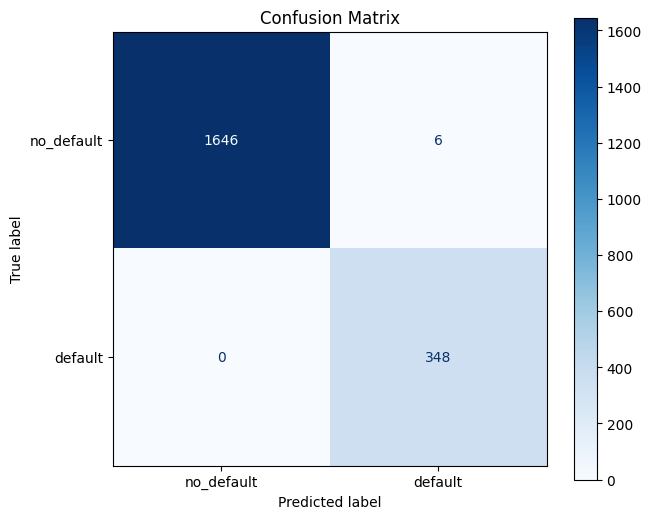

In [12]:
from sklearn.linear_model import LogisticRegression

# Définir les hyperparamètres du modèle
run_name="Logistic_regression_balanced_saga_elasticnet"
model_params = {
    "fit_intercept":True,
    "class_weight":'balanced',
    "penalty":'elasticnet',
    "solver":"saga",
    "l1_ratio":0.5,
    "max_iter":1000,
    "random_state":random_seed,
}

# Créer un modèle de régression logistique avec ces hyperparamètres
model = LogisticRegression(**model_params)

# Ajuster le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)

class_report,conf_matrix = eval_log_model(model, X_test, y_test,y_pred,model_params,run_name)

class_report

### B. Random Forest

Le modèle Random Forest repose sur un ensemble d’arbres décisionnels. Il permet de capturer des relations non linéaires et des interactions complexes dans les données. Grâce au vote majoritaire, il améliore la stabilité des prédictions et réduit le risque de surapprentissage.


In [13]:
# Définir le nom de l'expérience
experiment_tags = {"project_name":"Loan Default Prediction" ,"data": "Loan Data","team":"Alexandre-Jiwon-Patricia-Waï", "model": "Logistic Regression"}
logistic_regression_experiment = client.create_experiment(name="Random_Forest",tags=experiment_tags)

In [14]:
mlflow.set_experiment("Random_Forest")

<Experiment: artifact_location='file:///c:/Users/LENOVO/Desktop/Projet_MLOps-GenAI/mlruns/456862180105203272', creation_time=1763218109938, experiment_id='456862180105203272', last_update_time=1763218109938, lifecycle_stage='active', name='Random_Forest', tags={'data': 'Loan Data',
 'model': 'Logistic Regression',
 'project_name': 'Loan Default Prediction',
 'team': 'Alexandre-Jiwon-Patricia-Waï'}>

c:\Users\LENOVO\Desktop\Projet_MLOps-GenAI\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


{'default_precision': 0.99,
 'default_recall': 0.98,
 'default_f1_score': 0.99,
 'no_default_precision': 1.0,
 'no_default_recall': 1.0,
 'no_default_f1_score': 1.0,
 'false_positives': 2,
 'false_negatives': 8}

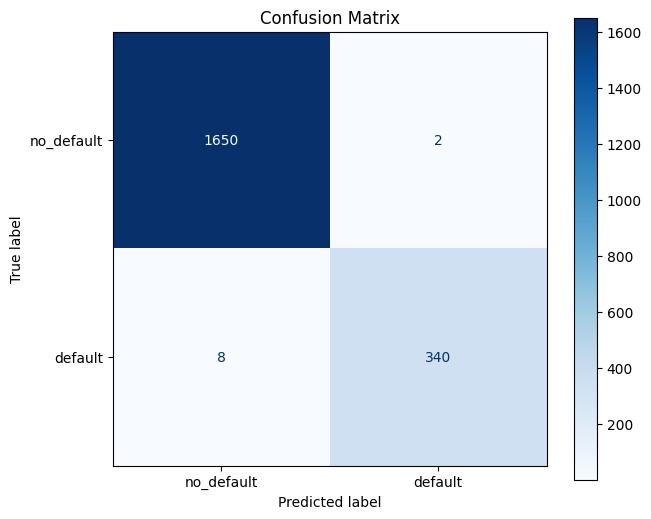

In [15]:
from sklearn.ensemble import RandomForestRegressor

# Définir les hyperparamètres du modèle
run_name="Random_Forest_depth_6_estimators_50"
model_params = {
    "n_estimators": 50,
    "max_depth": 6,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "bootstrap": True,
    "oob_score": False,
    "random_state":random_seed,
}

model = RandomForestRegressor(**model_params)

# Ajuster le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

class_report,conf_matrix = eval_log_model(model, X_test, y_test,y_pred, model_params,run_name)

class_report

### C. Arbre de décision

Le modèle d’arbre de décision constitue une approche plus simple et plus interprétable. Il permet de représenter les règles de décision de façon hiérarchique et de mieux comprendre les critères menant au défaut de paiement. Nous l’entraînons et l’évaluons ici dans une logique comparative avec la régression logistique et la Random Forest.


In [16]:
mlflow.set_experiment("Decision_Tree")

2025/11/15 15:48:45 INFO mlflow.tracking.fluent: Experiment with name 'Decision_Tree' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/LENOVO/Desktop/Projet_MLOps-GenAI/mlruns/542904955763916582', creation_time=1763218125795, experiment_id='542904955763916582', last_update_time=1763218125795, lifecycle_stage='active', name='Decision_Tree', tags={}>

c:\Users\LENOVO\Desktop\Projet_MLOps-GenAI\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


{'default_precision': 0.99,
 'default_recall': 0.99,
 'default_f1_score': 0.99,
 'no_default_precision': 1.0,
 'no_default_recall': 1.0,
 'no_default_f1_score': 1.0,
 'false_positives': 4,
 'false_negatives': 5}

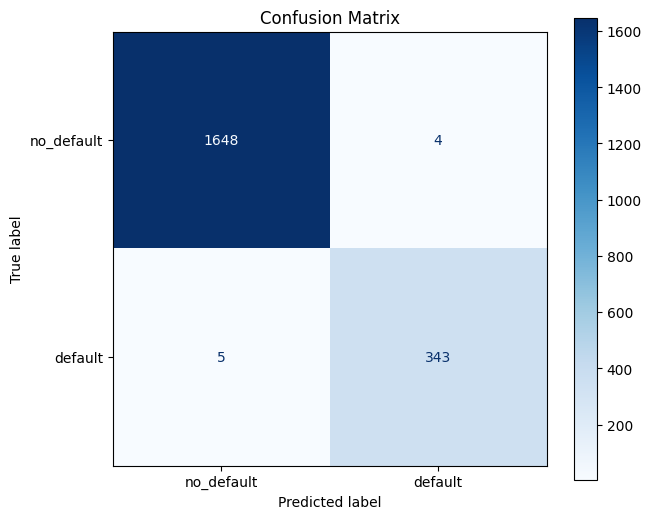

In [17]:
from sklearn.tree import DecisionTreeClassifier

# Définir les hyperparamètres du modèle d'arbre de décision
run_name = "DecisionTree_depth_5_minSamples10"
model_params = {
    "criterion": "gini",  # ou "entropy"
    "max_depth": 5,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "class_weight": "balanced",
    "random_state": random_seed,
}

# Créer un modèle d'arbre de décision avec ces hyperparamètres
model = DecisionTreeClassifier(**model_params)

# Ajuster le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)

# Évaluer et journaliser le modèle dans MLflow
metrics, fig = eval_log_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    y_pred=y_pred,
    params=model_params,
    run_name=run_name,
)

metrics


---

## 4. Sélection du meilleur modèle et conclusion

### A. Sélection manuelle du meilleur modèle



Dans cette dernière partie, nous exploitons les résultats journalisés dans MLflow afin d’identifier le modèle le plus performant parmi ceux testés (régression logistique, Random Forest et arbre de décision). Nous sélectionnons le run présentant le meilleur compromis entre précision, rappel et F1-score, puis nous exportons ce modèle final pour une réutilisation ultérieure.
Voici le meilleur modèle identifié d’après l’analyse des différents runs MLflow. Celui-ci présente les performances les plus élevées en termes de précision globale et d’équilibre entre les métriques clés. Le code ci-dessous permet de récupérer ce run, d’afficher ses paramètres principaux et de sauvegarder le modèle entraîné sous la forme d’un fichier `bestmodel.pkl`, prêt à être intégré dans un pipeline applicatif ou de déploiement.


In [18]:
experiment_id = "223661003783169431"  # Logistic_Regression

runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="",
    max_results=100
)

print(f"Nombre de runs trouvés : {len(runs)}\n")
for r in runs:
    print(f"- run_id={r.info.run_id} | run_name={r.info.run_name}")


Nombre de runs trouvés : 0



In [22]:
experiment_id = "542904955763916582"  # Logistic_Regression
run_name = "DecisionTree_depth_5_minSamples10"  # EXACTEMENT comme dans ton affichage

runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string=f"run_name = '{run_name}'",
    max_results=1
)

if not runs:
    print("⚠️ Aucun run trouvé avec ce nom.")
else:
    best_run = runs[0]
    print("✅ Run trouvé !")
    print("ID du run :", best_run.info.run_id)
    print("Nom du run :", best_run.info.run_name)

    print("\nParamètres du modèle :")
    for k, v in best_run.data.params.items():
        print(f"  {k}: {v}")

✅ Run trouvé !
ID du run : 5f8d784bfbda4e5c8b8afd1c21dbc525
Nom du run : DecisionTree_depth_5_minSamples10

Paramètres du modèle :
  class_weight: balanced
  criterion: gini
  max_depth: 5
  min_samples_leaf: 4
  min_samples_split: 10
  random_state: 42


In [20]:
"""
import joblib

# On réutilise best_run défini juste avant
run_id = best_run.info.run_id
artifact_path = best_run.info.run_name  # car artifact_path = run_name dans ton code

# Construire l'URI du modèle dans MLflow
model_uri = f"runs:/{run_id}/{artifact_path}"
print("Model URI :", model_uri)

# Charger le modèle depuis MLflow
best_model = mlflow.sklearn.load_model(model_uri)

# Sauvegarder le modèle en local
joblib.dump(best_model, "bestmodel.pkl")

print("✅ Modèle sauvegardé sous le nom 'bestmodel.pkl' dans le répertoire courant.")

"""

'\nimport joblib\n\n# On réutilise best_run défini juste avant\nrun_id = best_run.info.run_id\nartifact_path = best_run.info.run_name  # car artifact_path = run_name dans ton code\n\n# Construire l\'URI du modèle dans MLflow\nmodel_uri = f"runs:/{run_id}/{artifact_path}"\nprint("Model URI :", model_uri)\n\n# Charger le modèle depuis MLflow\nbest_model = mlflow.sklearn.load_model(model_uri)\n\n# Sauvegarder le modèle en local\njoblib.dump(best_model, "bestmodel.pkl")\n\nprint("✅ Modèle sauvegardé sous le nom \'bestmodel.pkl\' dans le répertoire courant.")\n\n'

### B. Sélection manuelle du meilleur modèle

Dans cette dernière partie, la sélection du meilleur modèle n’est plus réalisée manuellement via l’interface MLflow : elle est entièrement automatisée. Le code parcourt l’ensemble des runs journalisés (régression logistique, Random Forest et arbre de décision), récupère automatiquement la métrique cible (par exemple accuracy, recall, F1-score) et identifie le modèle présentant la meilleure performance selon ce critère.

Une fois le meilleur run détecté, ses paramètres, métriques et artefacts sont automatiquement extraits. Le modèle associé est ensuite chargé et sauvegardé sous le nom bestmodel.pkl, prêt à être intégré dans un pipeline MLOps (MLflow, Airflow, API FastAPI, déploiement en production, etc.). Cette approche garantit une sélection systématique, reproductible et objective du meilleur modèle, sans intervention manuelle.

Ce modèle est sauvegardé dans le fichier `bestmodel.pkl`

In [21]:
# 1️⃣ Paramètres de sélection
TARGET_EXPERIMENTS = ["Logistic_Regression", "Random_Forest", "Decision_Tree"]
METRIC_MAIN = "default_f1_score"
MIN_DEFAULT_RECALL = 0.80
MIN_DEFAULT_PRECISION = 0.60

# 2️⃣ Récupérer les IDs des expériences à comparer
experiments = client.search_experiments()
exp_ids = [e.experiment_id for e in experiments if e.name in TARGET_EXPERIMENTS]

print("Expériences prises en compte :", exp_ids)

# 3️⃣ Récupérer tous les runs qui respectent les contraintes
candidates = []
for exp_id in exp_ids:
    runs = client.search_runs(
        experiment_ids=[exp_id],
        filter_string=(
            f"metrics.default_recall >= {MIN_DEFAULT_RECALL} "
            f"and metrics.default_precision >= {MIN_DEFAULT_PRECISION}"
        ),
        max_results=1000,
    )
    candidates.extend(runs)

if not candidates:
    raise ValueError(
        f"Aucun modèle ne respecte les contraintes : "
        f"default_recall >= {MIN_DEFAULT_RECALL} et "
        f"default_precision >= {MIN_DEFAULT_PRECISION}."
    )

# 4️⃣ Choisir le run avec le meilleur F1 défaut
best_run = max(candidates, key=lambda r: r.data.metrics[METRIC_MAIN])

print("✅ Meilleur modèle sélectionné :")
print("  Expérience :", best_run.info.experiment_id)
print("  Run ID     :", best_run.info.run_id)
print("  Run name   :", best_run.info.run_name)
print("  F1 défaut  :", best_run.data.metrics["default_f1_score"])
print("  Recall def :", best_run.data.metrics["default_recall"])
print("  Prec def   :", best_run.data.metrics["default_precision"])

print("\nParamètres du modèle :")
for k, v in best_run.data.params.items():
    print(f"  {k}: {v}")

# 5️⃣ Charger le modèle MLflow correspondant et le sauvegarder en local
run_id = best_run.info.run_id
artifact_path = best_run.info.run_name   # car dans eval_log_model tu as mis artifact_path=run_name

model_uri = f"runs:/{run_id}/{artifact_path}"
print("\nModel URI utilisé :", model_uri)

best_model = mlflow.sklearn.load_model(model_uri)

output_path = "bestmodel.pkl"
joblib.dump(best_model, output_path)

print(f"💾 Modèle sauvegardé automatiquement sous '{output_path}'")


Expériences prises en compte : ['542904955763916582', '456862180105203272', '517414777675039320']
✅ Meilleur modèle sélectionné :
  Expérience : 542904955763916582
  Run ID     : 5f8d784bfbda4e5c8b8afd1c21dbc525
  Run name   : DecisionTree_depth_5_minSamples10
  F1 défaut  : 0.99
  Recall def : 0.99
  Prec def   : 0.99

Paramètres du modèle :
  class_weight: balanced
  criterion: gini
  max_depth: 5
  min_samples_leaf: 4
  min_samples_split: 10
  random_state: 42

Model URI utilisé : runs:/5f8d784bfbda4e5c8b8afd1c21dbc525/DecisionTree_depth_5_minSamples10
💾 Modèle sauvegardé automatiquement sous 'bestmodel.pkl'
